# LOG6302A — Analyse d’applications et Cyber-sécurité<br>Laboratoire #4

**Quentin Guidée (2206809), Nam Vu (2230468)**

Polytechnique Montréal – Hiver 2024


# 1. Extraction du DataFlow

In [37]:
import tempfile
from copy import deepcopy

from code_analysis import CFG, CFGReader, Graph
from dataflow import PossibleReachableReferences, PossiblyReachingDefinitions
from graphviz import Source
from IPython.display import Image


def show_graph(graph: Graph):
    """Afficher le graphe dans Jupyter"""
    dot = graph.to_dot()
    s = Source(dot)
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        s.render(f.name, format="png")
        display(Image(f.name + ".png"))


def show_in_out(
    cfg: CFG, in_dict: dict[int, set[int]], out_dict: dict[int, set[int]]
) -> CFG:
    """Annote un CFG avec les valeurs de in et out pour chaque noeud puis l'affiche"""
    cfg_copy = deepcopy(cfg)
    for nid in cfg_copy.get_node_ids():
        cfg_copy.set_image(
            nid,
            f"in={[cfg.get_image(v) for v in in_dict[nid]]} "
            f"out={[cfg.get_image(v) for v in out_dict[nid]]} "
            f"{cfg_copy.get_image(nid) or ''}",
        )
    show_graph(cfg_copy)
    return cfg_copy


cfg_reader = CFGReader()

defs_dataflow = PossiblyReachingDefinitions()
refs_dataflow = PossibleReachableReferences()

In [144]:
def generate_defs(cfg: CFG):
    defs_set = set()
    for nid in cfg.get_node_ids():
        if cfg.get_type(nid) == "Variable":
            defs_set.add(nid)
    return defs_set

def generate_refs(cfg: CFG):
    refs_set = set()
    for nid in cfg.get_node_ids():
        if cfg.get_type(nid) == "Variable":
            refs_set.add(nid)
    return refs_set

def generate_def_ref_chain(cfg: CFG):
    refs = generate_refs(cfg)
    reaching_defs_in, _ = defs_dataflow(cfg)
    pairs = []
    for ref in refs:
        for def_id in reaching_defs_in[ref]:
            if cfg.get_image(def_id) == cfg.get_image(ref) and def_id != ref:
                pairs.append((def_id, ref))
    return pairs

def generate_ref_def_chain(cfg: CFG):
    defs = generate_defs(cfg)
    reaching_refs_in, _ = refs_dataflow(cfg)
    pairs = []
    for def_id in defs:
        for ref in reaching_refs_in[def_id]:
            if cfg.get_image(def_id) == cfg.get_image(ref) and def_id != ref:
                pairs.append((def_id, ref))
    return pairs


def generate_chains(cfg: CFG):
    def_ref_chain = generate_def_ref_chain(cfg)
    ref_def_chain = generate_ref_def_chain(cfg)

    for def_id, ref_id in def_ref_chain:
        print(f"{cfg.get_image(def_id)} (ligne {cfg.get_position(def_id)[0]}) référencé à la ligne {cfg.get_position(ref_id)[0]}")

    for ref_id, def_id in ref_def_chain:
        print(f"{cfg.get_image(ref_id)} (ligne {cfg.get_position(ref_id)[0]}) définit à la ligne {cfg.get_position(def_id)[0]}")
    
    return def_ref_chain, ref_def_chain

In [170]:
cfg = cfg_reader.read_cfg("../tp4/part_1/test.php.cfg.json")

In [40]:
in_dict, out_dict = defs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [41]:
in_dict, out_dict = refs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [42]:
def_ref_chain, ref_def_chain = generate_chains(cfg)

b (ligne 2) référencé à la ligne 5
a (ligne 3) référencé à la ligne 6
a (ligne 3) référencé à la ligne 8
b (ligne 2) définit à la ligne 5
b (ligne 2) définit à la ligne 2
a (ligne 3) définit à la ligne 8
a (ligne 3) définit à la ligne 3
b (ligne 5) définit à la ligne 5
a (ligne 6) définit à la ligne 8
a (ligne 6) définit à la ligne 6
a (ligne 8) définit à la ligne 8


In [146]:
cfg = cfg_reader.read_cfg("../tp4/part_1/wordcount.php.cfg.json")

In [44]:
in_dict, out_dict = defs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [45]:
in_dict, out_dict = refs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [145]:
def_ref_chain, ref_def_chain = generate_chains(cfg)

meta_type (ligne 3) référencé à la ligne 14
meta_type (ligne 4) référencé à la ligne 14
meta_type (ligne 12) référencé à la ligne 14
object_id (ligne 8) référencé à la ligne 14
object_id (ligne 3) référencé à la ligne 14
object_id (ligne 9) référencé à la ligne 14
object_id (ligne 12) référencé à la ligne 14
meta_cache (ligne 13) référencé à la ligne 14
meta_key (ligne 3) référencé à la ligne 16
meta_cache (ligne 13) référencé à la ligne 17
meta_type (ligne 3) référencé à la ligne 4
object_id (ligne 3) référencé à la ligne 4
object_id (ligne 3) référencé à la ligne 8
object_id (ligne 8) référencé à la ligne 8
object_id (ligne 3) référencé à la ligne 8
object_id (ligne 8) référencé à la ligne 9
object_id (ligne 3) référencé à la ligne 9
object_id (ligne 8) référencé à la ligne 9
object_id (ligne 8) référencé à la ligne 12
object_id (ligne 3) référencé à la ligne 12
object_id (ligne 9) référencé à la ligne 12
meta_type (ligne 3) référencé à la ligne 12
meta_type (ligne 4) référencé à la 

# 2. Utilisation du DataFlow

In [196]:
def is_definition(cfg: CFG, nid: int) -> bool:
    return cfg.get_type(cfg.get_children(nid)[0]) == "ValueParameter" \
        or cfg.get_type(cfg.get_children(cfg.get_children(nid)[0])[0]) == "OptValueParameter" \
        or cfg.get_type(cfg.get_children(nid)[0]) == "BinOP" \
        or cfg.get_type(cfg.get_parents(nid)[0]) == "MemberDeclaration"

def print_ref_not_def(cfg: CFG, def_ref_chain: list[tuple[int, int]]):
    for nid in cfg.get_node_ids():
        if cfg.get_type(nid) == "Variable" and not is_definition(cfg, nid):
            found_def = False
            for def_ref in def_ref_chain:
                if def_ref[1] == nid:
                    found_def = True
            if not found_def:
                print(f"Variable {cfg.get_image(nid)} (ligne {cfg.get_position(nid)[0]}) n'est pas définie")


def print_def_not_ref(cfg: CFG, ref_def_chain: list[tuple[int, int]]):
    for nid in cfg.get_node_ids():
        if cfg.get_type(nid) == "Variable" and is_definition(cfg, nid):
            found_ref = False
            for ref_def in ref_def_chain:
                if ref_def[0] == nid:
                    found_ref = True
            if not found_ref:
                print(f"Variable {cfg.get_image(nid)} (ligne {cfg.get_position(nid)[0]}) n'est pas référencée")

In [181]:
cfg = cfg_reader.read_cfg("../tp4/part_1/test.php.cfg.json")
def_ref_chain, ref_def_chain = generate_chains(cfg)
print(def_ref_chain)
print(ref_def_chain)

b (ligne 2) référencé à la ligne 5
a (ligne 3) référencé à la ligne 6
a (ligne 3) référencé à la ligne 8
b (ligne 2) définit à la ligne 5
a (ligne 3) définit à la ligne 8
a (ligne 6) définit à la ligne 8
[(10859, 10866), (10862, 10871), (10862, 10875)]
[(10859, 10866), (10862, 10875), (10871, 10875)]


In [182]:
print_ref_not_def(cfg, def_ref_chain)
print_def_not_ref(cfg, ref_def_chain)

## 2.1

In [183]:
cfg = cfg_reader.read_cfg("../tp4/part_2/file1.php.cfg.json")

In [128]:
in_dict, out_dict = defs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [129]:
in_dict, out_dict = refs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [184]:
def_ref_chain, ref_def_chain = generate_chains(cfg)
print(def_ref_chain)
print(ref_def_chain)

out (ligne 5) référencé à la ligne 9
line (ligne 8) référencé à la ligne 9
out (ligne 9) référencé à la ligne 9
filename (ligne 3) référencé à la ligne 4
fp (ligne 7) référencé à la ligne 10
line (ligne 9) référencé à la ligne 10
line (ligne 8) référencé à la ligne 10
fp (ligne 7) référencé à la ligne 13
fp (ligne 4) référencé à la ligne 7
out (ligne 5) référencé à la ligne 15
fp (ligne 13) référencé à la ligne 14
fp (ligne 7) référencé à la ligne 14
line (ligne 7) référencé à la ligne 8
filename (ligne 3) définit à la ligne 4
out (ligne 9) définit à la ligne 15
line (ligne 9) définit à la ligne 8
out (ligne 9) définit à la ligne 15
fp (ligne 4) définit à la ligne 13
fp (ligne 4) définit à la ligne 7
fp (ligne 10) définit à la ligne 13
line (ligne 10) définit à la ligne 8
out (ligne 5) définit à la ligne 15
fp (ligne 7) définit à la ligne 13
line (ligne 7) définit à la ligne 8
[(9905, 9924), (9919, 9925), (9924, 9926), (9890, 9898), (9913, 9934), (9925, 9936), (9919, 9936), (9913, 9943

In [185]:
print_ref_not_def(cfg, def_ref_chain)
print_def_not_ref(cfg, ref_def_chain)

Variable fp (ligne 14) n'est pas référencée


## 2.2

In [186]:
cfg = cfg_reader.read_cfg("../tp4/part_2/file2.php.cfg.json")

In [32]:
in_dict, out_dict = defs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

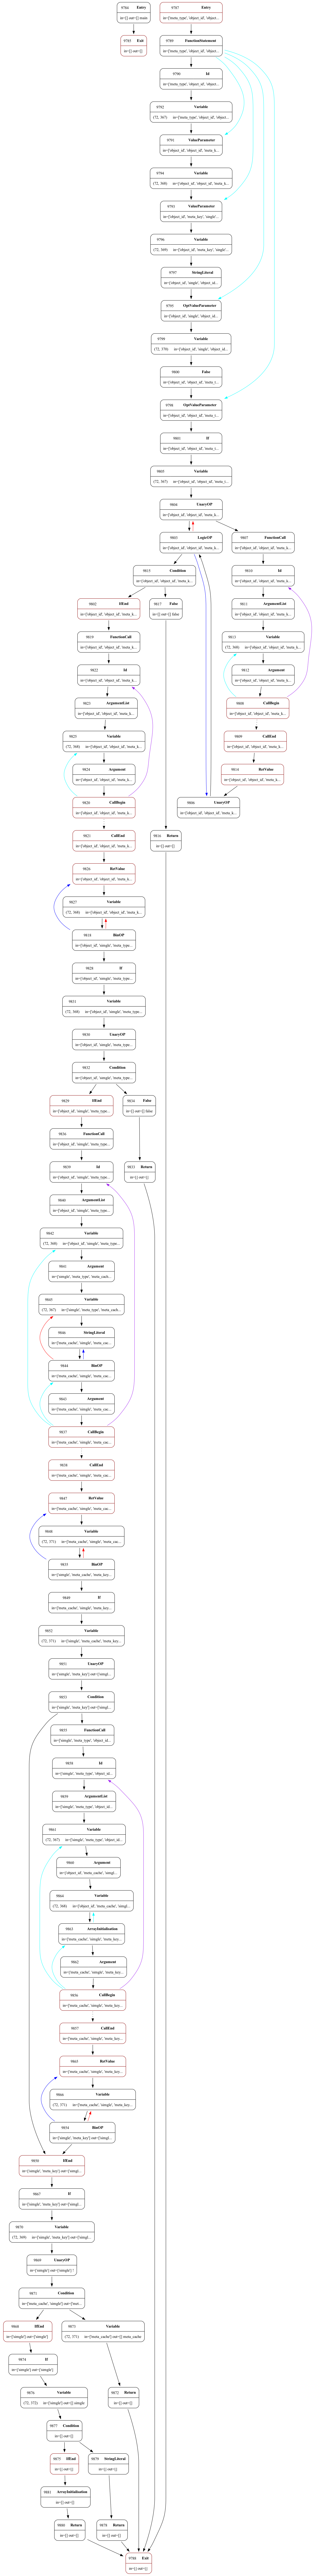

In [79]:
in_dict, out_dict = refs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [189]:
def_ref_chain, ref_def_chain = generate_chains(cfg)

meta_type (ligne 3) référencé à la ligne 14
meta_type (ligne 4) référencé à la ligne 14
meta_type (ligne 12) référencé à la ligne 14
object_id (ligne 8) référencé à la ligne 14
object_id (ligne 3) référencé à la ligne 14
object_id (ligne 9) référencé à la ligne 14
object_id (ligne 12) référencé à la ligne 14
meta_cache (ligne 13) référencé à la ligne 14
meta_key (ligne 3) référencé à la ligne 16
meta_cache (ligne 13) référencé à la ligne 17
meta_type (ligne 3) référencé à la ligne 4
object_id (ligne 3) référencé à la ligne 4
object_id (ligne 3) référencé à la ligne 8
object_id (ligne 8) référencé à la ligne 8
object_id (ligne 3) référencé à la ligne 8
object_id (ligne 8) référencé à la ligne 9
object_id (ligne 3) référencé à la ligne 9
object_id (ligne 8) référencé à la ligne 9
object_id (ligne 8) référencé à la ligne 12
object_id (ligne 3) référencé à la ligne 12
object_id (ligne 9) référencé à la ligne 12
meta_type (ligne 3) référencé à la ligne 12
meta_type (ligne 4) référencé à la 

In [190]:
print_ref_not_def(cfg, def_ref_chain)
print_def_not_ref(cfg, ref_def_chain)

Variable simgle (ligne 19) n'est pas définie
Variable single (ligne 3) n'est pas référencée
Variable meta_cache (ligne 14) n'est pas référencée


## 2.3

In [194]:
cfg = cfg_reader.read_cfg("../tp4/part_2/file3.php.cfg.json")

In [107]:
in_dict, out_dict = defs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [24]:
in_dict, out_dict = refs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [197]:
def_ref_chain, ref_def_chain = generate_chains(cfg)

charset (ligne 3249) référencé à la ligne 3281
charset (ligne 3271) référencé à la ligne 3281
charset (ligne 3237) référencé à la ligne 3281
regex (ligne 3272) référencé à la ligne 3282
regex (ligne 3272) référencé à la ligne 3289
regex (ligne 3282) référencé à la ligne 3289
regex (ligne 3289) référencé à la ligne 3293
value (ligne 3242) référencé à la ligne 3293
value (ligne 3223) référencé à la ligne 3293
value (ligne 3224) référencé à la ligne 3293
value (ligne 3226) référencé à la ligne 3293
value (ligne 3242) référencé à la ligne 3293
value (ligne 3223) référencé à la ligne 3293
value (ligne 3224) référencé à la ligne 3293
value (ligne 3226) référencé à la ligne 3293
value (ligne 3293) référencé à la ligne 3293
length (ligne 3230) référencé à la ligne 3295
value (ligne 3242) référencé à la ligne 3295
value (ligne 3223) référencé à la ligne 3295
value (ligne 3224) référencé à la ligne 3295
value (ligne 3226) référencé à la ligne 3295
value (ligne 3293) référencé à la ligne 3295
val

In [198]:
print_ref_not_def(cfg, def_ref_chain)
print_def_not_ref(cfg, ref_def_chain)

Variable show_errors (ligne 65) n'est pas définie
Variable suppress_errors (ligne 74) n'est pas définie
Variable last_error (ligne 83) n'est pas définie
Variable num_queries (ligne 92) n'est pas définie
Variable num_rows (ligne 101) n'est pas définie
Variable rows_affected (ligne 110) n'est pas définie
Variable insert_id (ligne 119) n'est pas définie
Variable last_query (ligne 128) n'est pas définie
Variable last_result (ligne 137) n'est pas définie
Variable result (ligne 155) n'est pas définie
Variable col_meta (ligne 164) n'est pas définie
Variable table_charset (ligne 173) n'est pas définie
Variable check_current_query (ligne 182) n'est pas définie
Variable checking_collation (ligne 192) n'est pas définie
Variable col_info (ligne 201) n'est pas définie
Variable queries (ligne 225) n'est pas définie
Variable reconnect_retries (ligne 235) n'est pas définie
Variable prefix (ligne 247) n'est pas définie
Variable base_prefix (ligne 256) n'est pas définie
Variable ready (ligne 265) n'est 

# 3.1

In [199]:
cfg = cfg_reader.read_cfg("../tp4/part_3/file.php.cfg.json")

In [201]:
in_dict, out_dict = defs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [211]:
for nid in cfg.get_node_ids():
    if cfg.get_type(nid) == "Variable":
        if cfg.get_image(nid) == "show_errors":
            parent = cfg.get_parents(nid)[0]
            child = cfg.get_children(nid)[0]
            print(cfg.get_type(parent))
            # print(cfg.get_type(child))

MemberDeclaration
